<a href="https://colab.research.google.com/github/atick-faisal/GRF-Synthesis-from-Motion-Trajectories/blob/main/src/training/grf_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade pandas==1.3.4

# Download and prepare data

In [2]:
!gdown --id "1kNGwWBQp6kmAioLP-_zWx7r42SzoEO3v"
!unzip UNet.zip

# !gdown --id "1LdXPJ8WwaDjFyUbRaAAPRWF_VWegA1jh"
!gdown --id "17hS6XZCy3g1HUKJV9f7E8Gta4IgCQypQ"

Downloading...
From: https://drive.google.com/uc?id=1kNGwWBQp6kmAioLP-_zWx7r42SzoEO3v
To: /content/UNet.zip
100% 737k/737k [00:00<00:00, 49.3MB/s]
Archive:  UNet.zip
  inflating: 1D_CNN_Segmentation_End2End_Pipeline.ipynb  
  inflating: AlbuNet_1DCNN.py        
  inflating: Dense_Inception_UNet_1DCNN.py  
  inflating: FPN_1DCNN.py            
  inflating: LinkNet_1DCNN.py        
  inflating: PSPNet_1DCNN.py         
  inflating: README.txt              
  inflating: TernausNet_1DCNN.py     
  inflating: UNet_1DCNN.py           
Downloading...
From: https://drive.google.com/uc?id=17hS6XZCy3g1HUKJV9f7E8Gta4IgCQypQ
To: /content/data2_f15_t3_n1.joblib
100% 578M/578M [00:10<00:00, 57.4MB/s]


# Import libraries

In [3]:
import h5py
import scipy
import random
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from UNet_1DCNN import UNet

%matplotlib inline
sns.set_style('white')

In [4]:
DATASET_ID = 2
FRAME_LEN = 1024

data = joblib.load(f'data{DATASET_ID}_f15_t3_n1.joblib')
features = data['X']
target = data['y']

if DATASET_ID == 1:
    features_z = features[['fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z']].to_numpy()
else:
    features_z = features[['7_z', '8_z', '9_z', '10_z', '11_z']].to_numpy()

target_z = target[['fz']].to_numpy()

N_CHANNELS = features_z.shape[1]

# feature_scaler_1 = StandardScaler()
feature_scaler_2 = MinMaxScaler()
# feature_scaler_1.fit(features_z)
# features_z = feature_scaler_1.transform(features_z)
feature_scaler_2.fit(features_z)
features_z = feature_scaler_2.transform(features_z)

# target_scaler_1 = StandardScaler()
target_scaler_2 = MinMaxScaler()
# target_scaler_1.fit(target_z)
# target_z = target_scaler_1.transform(target_z)
target_scaler_2.fit(target_z)
target_z = target_scaler_2.transform(target_z)

X = features_z.reshape(-1, FRAME_LEN, N_CHANNELS)
y = target_z.reshape(-1, FRAME_LEN, 1)

print(X.shape)
print(y.shape)

(3920, 1024, 5)
(3920, 1024, 1)


# Signal Verification

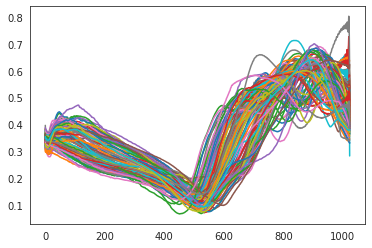

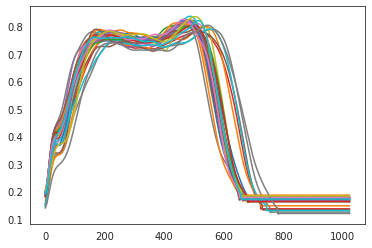

In [5]:
for i in range(100):
    plt.plot(X[i, :, 0])
plt.show()

for i in range(1800,1830):
    plt.plot(y[i, :])
plt.show()

# Train test split

In [6]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=0.2, random_state=42)
Y_Train = np.squeeze(Y_Train, axis=2)
Y_Test = np.squeeze(Y_Test, axis=2)
Y_Train.shape

(3136, 1024)

# Configuration

In [16]:
model_name = 'UNet' # UNet or UNetPP
signal_length = FRAME_LEN # Length of each Segment
model_depth = 3 # Number of Level in the CNN Model
model_width = 32 # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3 # Size of the Kernels/Filter
num_channel = N_CHANNELS # Number of Channels in the Model
D_S = 1 # Turn on Deep Supervision
A_E = 0 # Turn on AutoEncoder Mode for Feature Extraction
A_G = 1 # Attention Guided
problem_type = 'Regression'
output_nums = 1 # Number of Class for Classification Problems, always '1' for Regression Problems
'''Only required if the AutoEncoder Mode is turned on'''
feature_number = 1024 # Number of Features to be Extracted
'''Only required for MultiResUNet'''
alpha = 1 # Model Width Expansion Parameter

# Prepare for deep supervision

In [10]:
def prepareTrainDict(y, model_depth, signal_length, model_name):
  def approximate(inp, w_len, signal_length):
    op = np.zeros((len(inp),signal_length//w_len))
    for i in range(0,signal_length,w_len):
      try:
        op[:,i//w_len] = np.mean(inp[:,i:i+w_len],axis=1)
      except Exception as e:
        print(e)
        print(i)
  	
    return op

  out = {}
  Y_Train_dict = {}
  out['out'] = np.array(y)
  Y_Train_dict['out'] = out['out']
  for i in range(1, (model_depth+1)):
    name = f'level{i}'
    if ((model_name == 'UNet') or (model_name == 'MultiResUNet') or (model_name == 'FPN')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**i, signal_length),axis = 2)
    elif ((model_name == 'UNetE') or (model_name == 'UNetP') or (model_name == 'UNetPP')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**0, signal_length),axis = 2)
    Y_Train_dict[f'level{i}'] = out[f'level{i}']
  
  return out, Y_Train_dict

In [11]:
X_Train1 = X_Train
X_Test1 = X_Test
[Y_Train1, Y_Train_dict] = prepareTrainDict(Y_Train, model_depth, signal_length, model_name)
[Y_Test1, Y_Test_dict] = prepareTrainDict(Y_Test, model_depth, signal_length, model_name)

In [12]:
loss_weights = np.zeros(model_depth)

for i in range(0, model_depth):
   loss_weights[i] = 1-(i*0.1)
   
loss_weights

array([1. , 0.9, 0.8])

# Build and compile model

In [17]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001
)

if D_S == 0:
    # Build model for EEG Motion Artifact Removal - Deep Unet Architecture
    # AutoEncoder should be set at 'FALSE' for the Deep U-net model for Signal Reconstruction
    # D_S = 0, A_E = 0
    model = UNet(
        signal_length,
        model_depth,
        num_channel, 
        model_width, 
        kernel_size, 
        problem_type=problem_type, 
        output_nums=output_nums, 
        ds=D_S,
        ae=A_E, 
        ag=A_G,
        alpha=alpha
    ).UNet()

    model.compile(
        loss= 'mean_absolute_error', 
        optimizer= optimizer, 
        metrics= ['mean_squared_error','accuracy']
    )
    #
elif D_S == 1:
    # Build model for EEG Motion Artifact Removal - Deep Unet Architecture
    # AutoEncoder should be set at 'FALSE' for the Deep U-net model for Signal Reconstruction
    # D_S = 1, A_E = 0
    model = UNet(
        signal_length, model_depth, 
        num_channel, 
        model_width, 
        kernel_size, 
        problem_type=problem_type, 
        output_nums=output_nums, 
        ds=D_S,
        ae=A_E,
        ag=A_G, 
        alpha=alpha
    ).UNet()

    model.compile(
        loss= 'mean_absolute_error', 
        optimizer= optimizer, 
        metrics= ['mean_squared_error'], 
        loss_weights= loss_weights
    )

# Training

In [18]:
if D_S == 0:
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min'), 
        tf.keras.callbacks.ModelCheckpoint(
            'trained_models/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_' \
                +str(model_depth)+'_'+str(num_channel)+'_'+str(D_S)+'.h5', 
                verbose=1, 
                monitor='val_loss', 
                save_best_only=True, 
                mode='min'
        )
    ]
    history = model.fit(
        X_Train, Y_Train, 
        epochs=300, 
        batch_size=64, 
        verbose=1, 
        validation_split=0.2, 
        shuffle=True, 
        callbacks=callbacks
    )
    
elif D_S == 1:
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', patience=30, mode='min'), 
        tf.keras.callbacks.ModelCheckpoint(
            'trained_models/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_' \
                +str(model_depth)+'_'+str(num_channel)+'_'+str(D_S)+'.h5', 
                verbose=1, 
                monitor='val_out_loss', 
                save_best_only=True, 
                mode='min'
        )
    ]
    history = model.fit(
        X_Train1, 
        Y_Train_dict, 
        epochs=300, 
        batch_size=64, 
        verbose=1, 
        validation_split=0.2, 
        shuffle=True, 
        callbacks=callbacks
    )

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.7493 - out_loss: 0.1824 - level1_loss: 0.2174 - level2_loss: 0.2068 - level3_loss: 0.2261 - out_mean_squared_error: 0.1834 - level1_mean_squared_error: 0.3136 - level2_mean_squared_error: 0.3509 - level3_mean_squared_error: 0.2302
Epoch 00001: val_out_loss improved from inf to 0.28431, saving model to trained_models/UNet_1024_32_3_5_1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


40/40 [==============================] - 35s 275ms/step - loss: 0.7493 - out_loss: 0.1824 - level1_loss: 0.2174 - level2_loss: 0.2068 - level3_loss: 0.2261 - out_mean_squared_error: 0.1834 - level1_mean_squared_error: 0.3136 - level2_mean_squared_error: 0.3509 - level3_mean_squared_error: 0.2302 - val_loss: 1.0252 - val_out_loss: 0.2843 - val_level1_loss: 0.2916 - val_level2_loss: 0.2805 - val_level3_loss: 0.2826 - val_out_mean_squared_error: 0.1346 - val_level1_mean_squared_error: 0.1378 - val_level2_mean_squared_error: 0.1149 - val_level3_mean_squared_error: 0.1131
Epoch 2/300
40/40 [==============================] - ETA: 0s - loss: 0.2601 - out_loss: 0.0707 - level1_loss: 0.0722 - level2_loss: 0.0719 - level3_loss: 0.0742 - out_mean_squared_error: 0.0127 - level1_mean_squared_error: 0.0148 - level2_mean_squared_error: 0.0152 - level3_mean_squared_error: 0.0137
Epoch 00002: val_out_loss improved from 0.28431 to 0.25889, saving model to trained_models/UNet_1024_32_3_5_1.h5
40/40 [====

# Prediction

In [19]:
if D_S == 0:
    GRF_pred = model.predict(X_Test, verbose=1)
    print(GRF_pred.shape)
elif D_S == 1:
    GRF_pred = model.predict(X_Test1, verbose=1)
    print(GRF_pred[0].shape)

25/25 [==============================] - 3s 36ms/step
(784, 1024, 1)


# Learning curves

dict_keys(['loss', 'out_loss', 'level1_loss', 'level2_loss', 'level3_loss', 'out_mean_squared_error', 'level1_mean_squared_error', 'level2_mean_squared_error', 'level3_mean_squared_error', 'val_loss', 'val_out_loss', 'val_level1_loss', 'val_level2_loss', 'val_level3_loss', 'val_out_mean_squared_error', 'val_level1_mean_squared_error', 'val_level2_mean_squared_error', 'val_level3_mean_squared_error'])


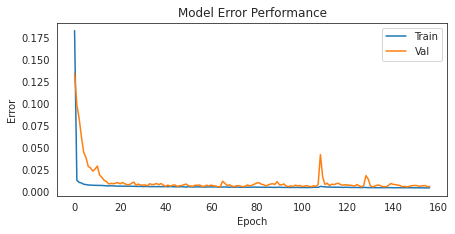

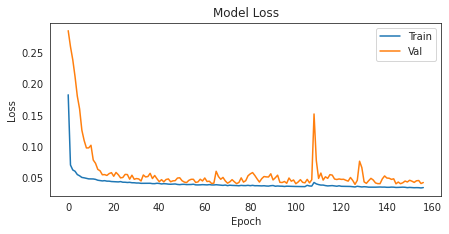

In [20]:
def history_plot(history):
    # list all dictionaries in history
    print(history.history.keys())
    # summarize history for error
    plt.figure(figsize=(7,7))
    plt.subplot(2,1,1)
    plt.plot(history.history['out_mean_squared_error'])
    plt.plot(history.history['val_out_mean_squared_error'])
    plt.title('Model Error Performance')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    #   plt.ylim([0, 3])
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(7,7))
    plt.subplot(2,1,2)
    plt.plot(history.history['out_loss'])
    plt.plot(history.history['val_out_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    #   plt.ylim([0, 3])
    plt.show()
#
history_plot(history)

# Visualize outcomes

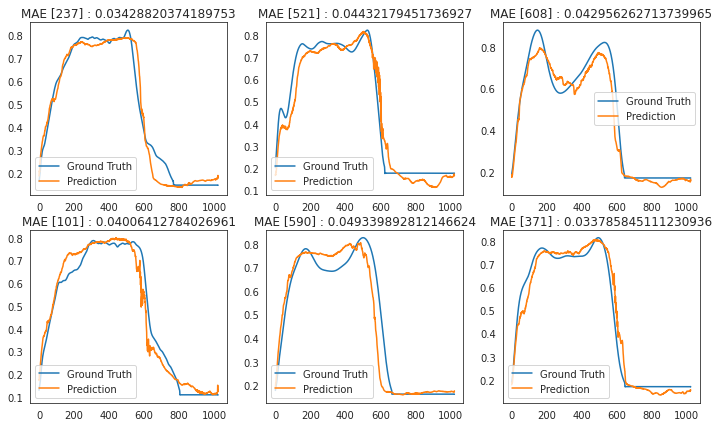

In [21]:
if D_S == 0:
    random_idx = random.sample(range(0, Y_Test.shape[0]), 6)
    plt.figure(figsize=(12, 7))
    for i in range(6):
        y_true = Y_Test[random_idx[i]]
        y_pred = GRF_pred[random_idx[i]]
        MAE = np.mean(np.abs(y_pred.ravel() - y_true.ravel()))
        plt.subplot(2, 3, i + 1)
        plt.plot(y_true, label='Ground Truth')
        plt.plot(y_pred.ravel(), label='Prediction')
        plt.title(f"MAE [{random_idx[i]}] : {MAE}")
        plt.legend();
    plt.show()
    
elif D_S == 1:
    random_idx = random.sample(range(0, Y_Test.shape[0]), 6)
    plt.figure(figsize=(12, 7))
    for i in range(6):
        y_true = Y_Test[random_idx[i]]
        y_pred = GRF_pred[0][random_idx[i]]
        MAE = np.mean(np.abs(y_pred.ravel() - y_true.ravel()))
        plt.subplot(2, 3, i + 1)
        plt.plot(y_true, label='Ground Truth')
        plt.plot(y_pred.ravel(), label='Prediction')
        plt.title(f"MAE [{random_idx[i]}] : {MAE}")
        plt.legend();
    plt.show()

# Construction Error

In [22]:
def Construction_Error(GRND, Pred):
    construction_err = []
    bad_indices = []
    count = 0

    for i in range(len(GRND)):
        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        if MAE < 1:
            construction_err.append(MAE)
        elif MAE >= 1:
            count = count + 1
            bad_indices.append(i)

    print(f'Construction Error : {round(np.mean(construction_err), 3)} +/- {round(np.std(construction_err), 3)}')
    print(f'Number of Bad Predictions = {count}')

    bad_indices = set(bad_indices)
    all_indices = set(np.arange(len(GRND)))
    good_indices = np.array(list(all_indices - bad_indices))
    GRND_NEW = GRND[good_indices]
    PRED_NEW = Pred[good_indices]

    return GRND_NEW, PRED_NEW

In [ ]:
[A,B] = Construction_Error(Y_Test, GRF_pred[0])

# Infinite loop to keep colab alive

In [ ]:
while True:
    pass